## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.25, 0.5, 0.75]
redice_lr_patient = [5, 10, 15]

In [8]:
import itertools
from keras.callbacks import ReduceLROnPlateau
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.25, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

Epoch 11/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.2737 - accuracy: 0.5582 - val_loss: 1.4803 - val_accuracy: 0.4724
Epoch 12/25
50000/50000 [==============================] - 5s 97us/step - loss: 1.2474 - accuracy: 0.5680 - val_loss: 1.4872 - val_accuracy: 0.4672
Epoch 13/25
50000/50000 [==============================] - 5s 102us/step - loss: 1.2216 - accuracy: 0.5767 - val_loss: 1.4761 - val_accuracy: 0.4765
Epoch 14/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.1989 - accuracy: 0.5860 - val_loss: 1.4684 - val_accuracy: 0.4786
Epoch 15/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.1722 - accuracy: 0.5957 - val_loss: 1.4684 - val_accuracy: 0.4823
Epoch 16/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.1480 - accuracy: 0.6045 - val_loss: 1.4620 - val_accuracy: 0.4771
Epoch 17/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.1250 - accuracy: 0.6137 

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 104us/step - loss: 2.1734 - accuracy: 0.2827 - val_loss: 2.1281 - val_accuracy: 0.2341
Epoch 2/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.7259 - accuracy: 0.3989 - val_loss: 1.9628 - val_accuracy: 0.3018
Epoch 3/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.6063 - accuracy: 0.4404 - val_loss: 1.8201 - val_accuracy: 0.3685
Epoch 4/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.5323 - accuracy: 0.4680 - val_loss: 1.7126 - val_accuracy: 0.4081
Epoch 5/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.4801 - accuracy: 0.4868 - val_loss: 1.6201 - val_accuracy: 0.4370
Epoch 6/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.4340 - accuracy: 0.5031 - val_loss: 1.5717 - val_accuracy: 0.4506
Epoch 7/25
50000/50000 [==============================] - 5s 93us/s

50000/50000 [==============================] - 5s 93us/step - loss: 1.2419 - accuracy: 0.5742 - val_loss: 1.5048 - val_accuracy: 0.4707
Epoch 21/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.2264 - accuracy: 0.5796 - val_loss: 1.4986 - val_accuracy: 0.4722
Epoch 22/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.2110 - accuracy: 0.5852 - val_loss: 1.4944 - val_accuracy: 0.4720
Epoch 23/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.1946 - accuracy: 0.5909 - val_loss: 1.4926 - val_accuracy: 0.4752
Epoch 24/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.1791 - accuracy: 0.5964 - val_loss: 1.4894 - val_accuracy: 0.4707
Epoch 25/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.1658 - accuracy: 0.6024 - val_loss: 1.4887 - val_accuracy: 0.4766
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 15
Model: "model_6"
________________________________________________

Epoch 5/25
50000/50000 [==============================] - 5s 97us/step - loss: 1.5993 - accuracy: 0.4394 - val_loss: 1.7348 - val_accuracy: 0.3916
Epoch 6/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.5565 - accuracy: 0.4550 - val_loss: 1.6786 - val_accuracy: 0.4085
Epoch 7/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.5190 - accuracy: 0.4676 - val_loss: 1.6333 - val_accuracy: 0.4266
Epoch 8/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.4860 - accuracy: 0.4793 - val_loss: 1.6084 - val_accuracy: 0.4329
Epoch 9/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.4568 - accuracy: 0.4905 - val_loss: 1.5806 - val_accuracy: 0.4420
Epoch 10/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.4314 - accuracy: 0.5004 - val_loss: 1.5669 - val_accuracy: 0.4514
Epoch 11/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.4074 - accuracy: 0.5077 - val_l

Epoch 25/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.1576 - accuracy: 0.6036 - val_loss: 1.4887 - val_accuracy: 0.4791
Numbers of exp: 8, reduce_factor: 0.75, reduce_patient: 15
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_25 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_26 (Batc (None, 256)               1024      
_________________________________________________

50000/50000 [==============================] - 5s 107us/step - loss: 1.0407 - accuracy: 0.6354 - val_loss: 1.9597 - val_accuracy: 0.3677
Epoch 10/25
50000/50000 [==============================] - 6s 110us/step - loss: 0.9977 - accuracy: 0.6506 - val_loss: 1.7688 - val_accuracy: 0.4131

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11/25
50000/50000 [==============================] - 6s 112us/step - loss: 0.8720 - accuracy: 0.7003 - val_loss: 1.4614 - val_accuracy: 0.4908
Epoch 12/25
50000/50000 [==============================] - 6s 111us/step - loss: 0.8157 - accuracy: 0.7243 - val_loss: 1.4837 - val_accuracy: 0.4887
Epoch 13/25
50000/50000 [==============================] - 6s 113us/step - loss: 0.7858 - accuracy: 0.7364 - val_loss: 1.4488 - val_accuracy: 0.5002
Epoch 14/25
50000/50000 [==============================] - 6s 111us/step - loss: 0.7590 - accuracy: 0.7444 - val_loss: 1.4138 - val_accuracy: 0.5151
Epoch 15/25
50000/50000 [============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 127us/step - loss: 2.0649 - accuracy: 0.3070 - val_loss: 2.1143 - val_accuracy: 0.1996
Epoch 2/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.6885 - accuracy: 0.4123 - val_loss: 1.9419 - val_accuracy: 0.3202
Epoch 3/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.5967 - accuracy: 0.4458 - val_loss: 1.8164 - val_accuracy: 0.3794
Epoch 4/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.5389 - accuracy: 0.4652 - val_loss: 1.7085 - val_accuracy: 0.4166
Epoch 5/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.4950 - accuracy: 0.4789 - val_loss: 1.6381 - val_accuracy: 0.4373
Epoch 6/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.4589 - accuracy: 0.4920 - val_loss: 1.5957 - val_accuracy: 0.4453
Epoch 7/25
50000/50000 [==============================] - 5s 9

Epoch 21/25
50000/50000 [==============================] - 5s 102us/step - loss: 1.1775 - accuracy: 0.5993 - val_loss: 1.4830 - val_accuracy: 0.4838
Epoch 22/25
50000/50000 [==============================] - 5s 99us/step - loss: 1.1658 - accuracy: 0.6055 - val_loss: 1.4788 - val_accuracy: 0.4852
Epoch 23/25
50000/50000 [==============================] - 5s 102us/step - loss: 1.1545 - accuracy: 0.6088 - val_loss: 1.4786 - val_accuracy: 0.4844
Epoch 24/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.1425 - accuracy: 0.6147 - val_loss: 1.4794 - val_accuracy: 0.4863
Epoch 25/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.1321 - accuracy: 0.6168 - val_loss: 1.4718 - val_accuracy: 0.4903
Numbers of exp: 13, reduce_factor: 0.50, reduce_patient: 10
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 3072)     

50000/50000 [==============================] - 5s 105us/step - loss: 1.4856 - accuracy: 0.4839 - val_loss: 1.6528 - val_accuracy: 0.4326
Epoch 6/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.4499 - accuracy: 0.4964 - val_loss: 1.6047 - val_accuracy: 0.4430
Epoch 7/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.4207 - accuracy: 0.5079 - val_loss: 1.5744 - val_accuracy: 0.4468
Epoch 8/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.3931 - accuracy: 0.5179 - val_loss: 1.5521 - val_accuracy: 0.4582
Epoch 9/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.3675 - accuracy: 0.5278 - val_loss: 1.5453 - val_accuracy: 0.4606
Epoch 10/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.3464 - accuracy: 0.5348 - val_loss: 1.5263 - val_accuracy: 0.4628
Epoch 11/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.3266 - accuracy: 0.5436 - val_loss: 1.5

Epoch 25/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.1481 - accuracy: 0.6107 - val_loss: 1.4833 - val_accuracy: 0.4847
Numbers of exp: 16, reduce_factor: 0.75, reduce_patient: 10
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_49 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_50 (Batc (None, 256)               1024      
_______________________________________________

50000/50000 [==============================] - 6s 119us/step - loss: 1.3603 - accuracy: 0.5313 - val_loss: 1.5332 - val_accuracy: 0.4566
Epoch 10/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.3381 - accuracy: 0.5395 - val_loss: 1.5256 - val_accuracy: 0.4630
Epoch 11/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.3180 - accuracy: 0.5469 - val_loss: 1.5187 - val_accuracy: 0.4685
Epoch 12/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.2998 - accuracy: 0.5538 - val_loss: 1.5088 - val_accuracy: 0.4705
Epoch 13/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.2825 - accuracy: 0.5604 - val_loss: 1.5089 - val_accuracy: 0.4706
Epoch 14/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.2663 - accuracy: 0.5657 - val_loss: 1.5064 - val_accuracy: 0.4740
Epoch 15/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.2504 - accuracy: 0.5717 - val_loss:

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 125us/step - loss: 2.0014 - accuracy: 0.3214 - val_loss: 2.1344 - val_accuracy: 0.1917
Epoch 2/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.6901 - accuracy: 0.4101 - val_loss: 1.9502 - val_accuracy: 0.3128
Epoch 3/25
50000/50000 [==============================] - 5s 110us/step - loss: 1.5757 - accuracy: 0.4459 - val_loss: 1.7890 - val_accuracy: 0.3798
Epoch 4/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.4977 - accuracy: 0.4753 - val_loss: 1.6853 - val_accuracy: 0.4190
Epoch 5/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.4366 - accuracy: 0.4982 - val_loss: 1.6244 - val_accuracy: 0.4336
Epoch 6/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.3861 - accuracy: 0.5157 - val_loss: 1.5922 - val_accuracy: 0.4330
Epoch 7/25
50000/50000 [==============================] - 6s 1

Epoch 20/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.3438 - accuracy: 0.5384 - val_loss: 1.5723 - val_accuracy: 0.4597
Epoch 21/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.3296 - accuracy: 0.5442 - val_loss: 1.5614 - val_accuracy: 0.4589
Epoch 22/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.3151 - accuracy: 0.5487 - val_loss: 1.5610 - val_accuracy: 0.4570
Epoch 23/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.3027 - accuracy: 0.5543 - val_loss: 1.5588 - val_accuracy: 0.4584
Epoch 24/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.2903 - accuracy: 0.5588 - val_loss: 1.5513 - val_accuracy: 0.4586
Epoch 25/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.2775 - accuracy: 0.5638 - val_loss: 1.5456 - val_accuracy: 0.4604
Numbers of exp: 21, reduce_factor: 0.50, reduce_patient: 5
Model: "model_22"
_____________________________

50000/50000 [==============================] - 6s 117us/step - loss: 1.8015 - accuracy: 0.3755 - val_loss: 1.8992 - val_accuracy: 0.3207
Epoch 5/25
50000/50000 [==============================] - 6s 122us/step - loss: 1.7331 - accuracy: 0.3985 - val_loss: 1.8029 - val_accuracy: 0.3642
Epoch 6/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.6797 - accuracy: 0.4156 - val_loss: 1.7588 - val_accuracy: 0.3755
Epoch 7/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.6368 - accuracy: 0.4307 - val_loss: 1.7121 - val_accuracy: 0.3908
Epoch 8/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.6005 - accuracy: 0.4405 - val_loss: 1.6817 - val_accuracy: 0.4073
Epoch 9/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.5681 - accuracy: 0.4525 - val_loss: 1.6611 - val_accuracy: 0.4173
Epoch 10/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.5392 - accuracy: 0.4622 - val_loss: 1.637

Epoch 24/25
50000/50000 [==============================] - 5s 102us/step - loss: 1.2896 - accuracy: 0.5589 - val_loss: 1.5466 - val_accuracy: 0.4657
Epoch 25/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.2784 - accuracy: 0.5624 - val_loss: 1.5488 - val_accuracy: 0.4675
Numbers of exp: 24, reduce_factor: 0.75, reduce_patient: 5
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_73 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_______________________________

50000/50000 [==============================] - 5s 103us/step - loss: 1.5942 - accuracy: 0.4431 - val_loss: 1.6843 - val_accuracy: 0.4069
Epoch 9/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.5624 - accuracy: 0.4538 - val_loss: 1.6569 - val_accuracy: 0.4184
Epoch 10/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.5339 - accuracy: 0.4648 - val_loss: 1.6491 - val_accuracy: 0.4227
Epoch 11/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.5069 - accuracy: 0.4745 - val_loss: 1.6331 - val_accuracy: 0.4286
Epoch 12/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.4839 - accuracy: 0.4820 - val_loss: 1.6275 - val_accuracy: 0.4288
Epoch 13/25
50000/50000 [==============================] - 5s 105us/step - loss: 1.4612 - accuracy: 0.4890 - val_loss: 1.6174 - val_accuracy: 0.4374
Epoch 14/25
50000/50000 [==============================] - 5s 102us/step - loss: 1.4403 - accuracy: 0.4993 - val_loss: 

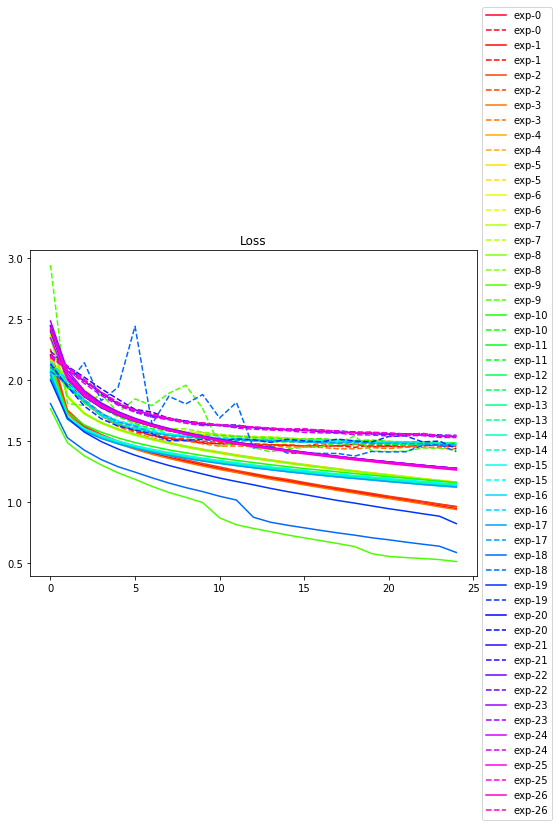

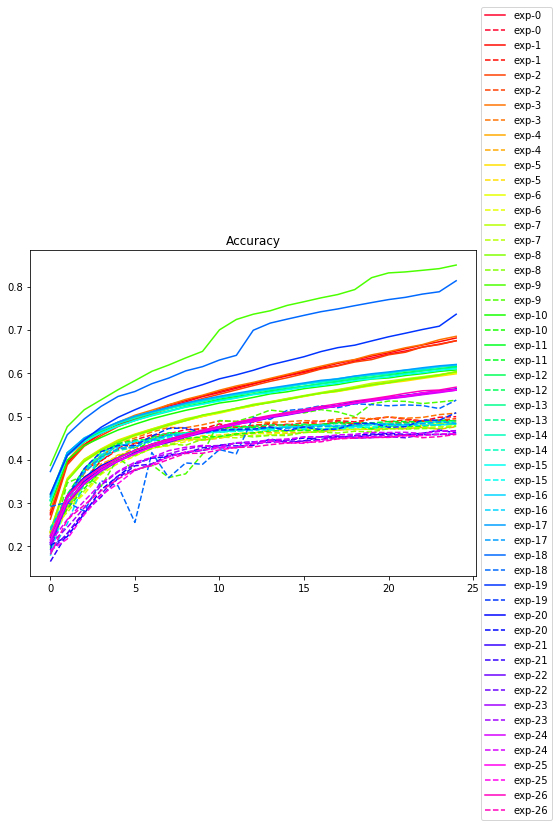

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()